In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import warnings

warnings.filterwarnings('ignore')

In [10]:
sales_data = pd.read_excel('../data/raw_data/SampleSize.xlsx', sheet_name= 'Sales Data - From View')
# vehi_data = pd.read_excel('SampleSize.xlsx', sheet_name= 'Vehicle Data - From Table')
# vehi_loc = pd.read_excel('SampleSize.xlsx', sheet_name= 'Vehicle Locations - From View')
# site_data = pd.read_excel('SampleSize.xlsx', sheet_name= 'Site Details - Manual add')

In [ ]:
pd.options.display.max_columns = None

In [1]:
data = sales_data.INVOICEDAT.value_counts().reset_index().sort_values(by='INVOICEDAT').reset_index(drop=True)
data = data.set_index('INVOICEDAT')
data

NameError: name 'sales_data' is not defined

In [64]:
from pmdarima import auto_arima

model = auto_arima(data['count'], seasonal=False, stepwise=True)
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  903
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -4128.805
Date:                Thu, 24 Oct 2024   AIC                           8277.611
Time:                        22:37:42   BIC                           8325.657
Sample:                             0   HQIC                          8295.963
                                - 903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2181      0.051      4.281      0.000       0.118       0.318
ar.L2         -0.9510      0.048    -19.799      0.000      -1.045      -0.857
ar.L3          0.0428      0.051      0.840      0.4

C:\Users\amank\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


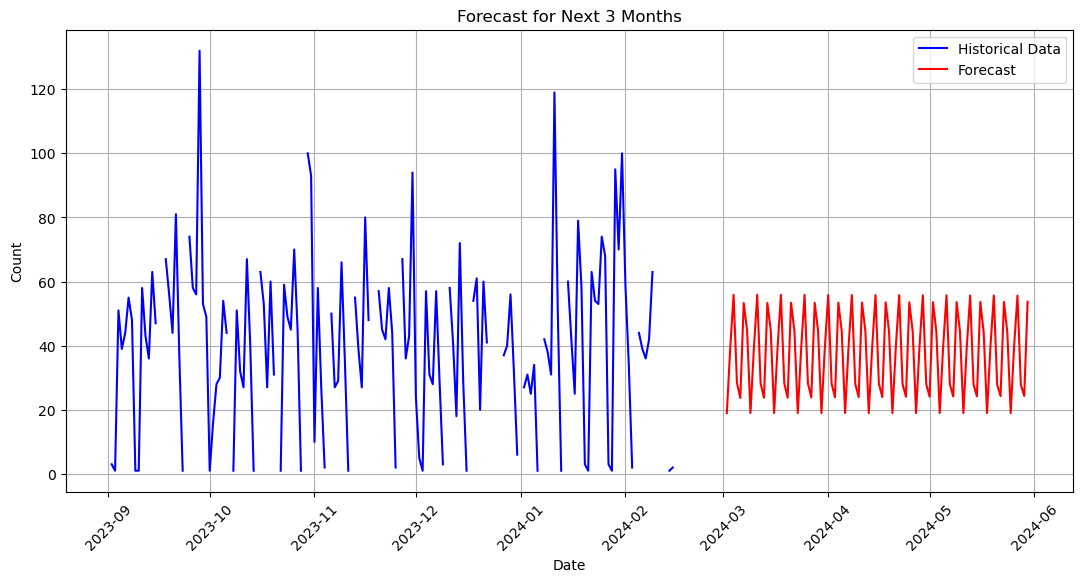

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# Ensure the index is a datetime type
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# Fit the ARIMA model (p, d, q parameters need tuning)
model = ARIMA(data['count'], order=(4, 1, 5))  # Example order, tune as necessary
model_fit = model.fit()

# Forecast for the next 90 days
forecast = model_fit.forecast(steps=90)

# Create a date range for the forecast
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the historical data and the forecast
plt.figure(figsize=(13, 6))
plt.plot(data.index[870:], data['count'][870:], label='Historical Data', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Forecast for Next 3 Months')
plt.legend()
plt.grid()
plt.show()

In [87]:
data = data.resample('M').sum()

In [88]:
from pmdarima import auto_arima

model = auto_arima(data['count'], seasonal=False, stepwise=True)
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -255.383
Date:                Thu, 24 Oct 2024   AIC                            516.765
Time:                        22:52:31   BIC                            521.516
Sample:                    04-30-2021   HQIC                           518.423
                         - 03-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    632.9841    162.048      3.906      0.000     315.376     950.592
ar.L1          0.3192      0.179      1.779      0.075      -0.032       0.671
sigma2      8.506e+04   1.93e+04      4.407      0.0

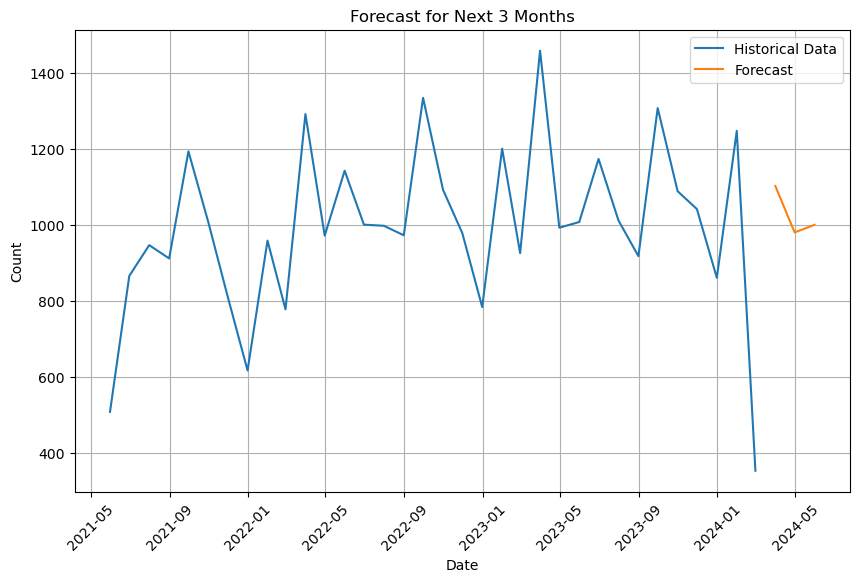

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# Ensure the index is a datetime type and prepare data for Prophet
data = sales_data.INVOICEDAT.value_counts().reset_index().sort_values(by='INVOICEDAT').reset_index(drop=True)
data = data.set_index('INVOICEDAT')
data.index = pd.to_datetime(data.index)

# Convert the data to monthly frequency and sum values within each month
data = data.resample('M').sum()

data = data[(data.index > data.index.min()) & (data.index < data.index.max())]

# Fit the ARIMA model (p, d, q parameters need tuning)
model = ARIMA(data['count'], order=(1, 0, 0))  # Example order, tune as necessary
model_fit = model.fit()

# Forecast for the next 90 days
forecast = model_fit.forecast(steps=3)

# Create a date range for the forecast
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=3, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the historical data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['count'], label='Historical Data')
plt.plot(forecast_series.index, forecast_series, label='Forecast')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Forecast for Next 3 Months')
plt.legend()
plt.grid()
plt.show()

In [92]:
forecast_series.values.sum()

1943.0896487550376

Mean Absolute Error: 24.290199309722798
Mean Squared Error: 847.7721194180933


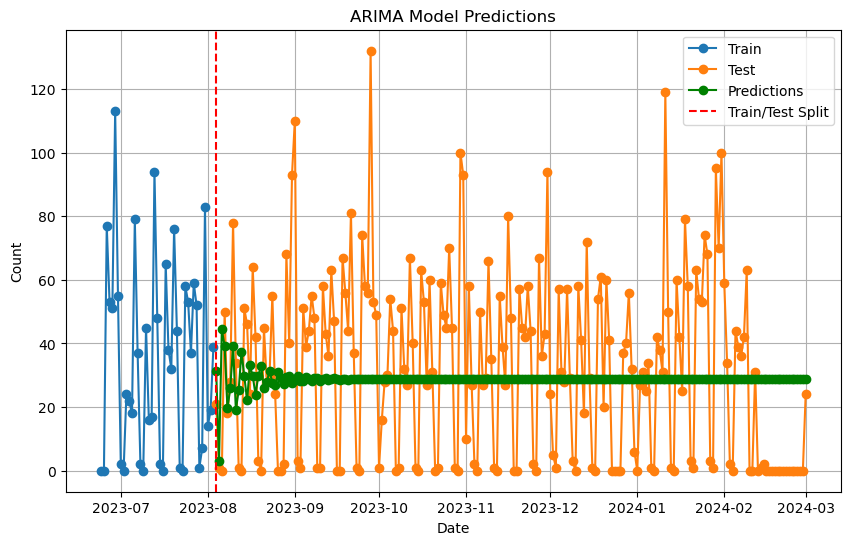

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Ensure the index is a datetime type and prepare data for Prophet
data = sales_data.INVOICEDAT.value_counts().reset_index().sort_values(by='INVOICEDAT').reset_index(drop=True)
data = data.set_index('INVOICEDAT')
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# Check for and handle missing values
data['count'] = data['count'].fillna(0)  # Or use forward fill, interpolation, etc.

# Split the data into training and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Fit the ARIMA model
model = ARIMA(train_data['count'], order=(5, 1, 0))  # Tune parameters as necessary
arima_model = model.fit()

# Get predictions on the test data
forecast = arima_model.get_forecast(steps=len(test_data))
predictions = forecast.predicted_mean

# Create an index for predictions that matches the test data index
predictions_index = test_data.index

# Set the index of predictions
predictions = pd.Series(predictions, index=predictions_index)

# Calculate error metrics
mae = mean_absolute_error(test_data['count'], predictions)
mse = mean_squared_error(test_data['count'], predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Optional: Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(train_data.index[800:], train_data['count'][800:], label='Train', marker='o')
plt.plot(test_data.index, test_data['count'], label='Test', marker='o')
plt.plot(predictions.index, predictions, label='Predictions', color='g', marker='o')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('ARIMA Model Predictions')
plt.axvline(test_data.index[0], color='r', linestyle='--', label='Train/Test Split')
plt.legend()
plt.grid()
plt.show()


In [10]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(train_data['count'], seasonal=False)
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  841
Model:               SARIMAX(1, 1, 5)   Log Likelihood               -3883.835
Date:                Thu, 24 Oct 2024   AIC                           7781.671
Time:                        23:39:29   BIC                           7814.804
Sample:                    04-15-2021   HQIC                          7794.370
                         - 08-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8650      0.118     -7.331      0.000      -1.096      -0.634
ma.L1          0.2125      0.119      1.783      0.075      -0.021       0.446
ma.L2         -1.1509      0.086    -13.322      0.0

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_data['count'])
print(f'p-value: {result[1]}')  # A p-value < 0.05 suggests stationarity


p-value: 7.381828497068599e-06


Mean Absolute Error: 24.382554119546782
Mean Squared Error: 845.4642535616844


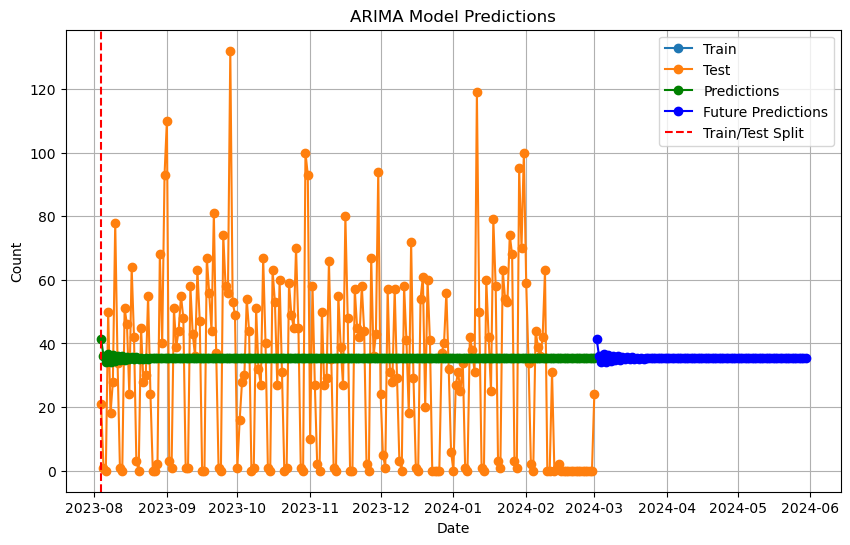

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure the index is a datetime type and has daily frequency
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')  # Ensure daily frequency

# Check for and handle missing values
data['count'] = data['count'].fillna(0)  # Or use forward fill, interpolation, etc.

# Split the data into training and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Fit the ARIMA model
model = ARIMA(train_data['count'], order=(1,1,5))  # Tune parameters as necessary
arima_model = model.fit()

# Get predictions on the test data
forecast = arima_model.get_forecast(steps=len(test_data))
predictions = forecast.predicted_mean

# Create an index for predictions that matches the test data index
predictions_index = test_data.index

# Set the index of predictions
predictions = pd.Series(predictions, index=predictions_index)

# Calculate error metrics
mae = mean_absolute_error(test_data['count'], predictions)
mse = mean_squared_error(test_data['count'], predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Forecast for the next three months (approx. 90 days)
future_steps = 90
future_forecast = arima_model.get_forecast(steps=future_steps)
future_predictions = future_forecast.predicted_mean

# Create a date range for future predictions
future_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
future_predictions = pd.Series(future_predictions.values, index=future_index)

# Optional: Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(train_data[870:], train_data['count'][870:], label='Train', marker='o')
plt.plot(test_data.index, test_data['count'], label='Test', marker='o')
plt.plot(predictions.index, predictions, label='Predictions', color='g', marker='o')
plt.plot(future_predictions.index, future_predictions, label='Future Predictions', color='blue', marker='o')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('ARIMA Model Predictions')
plt.axvline(test_data.index[0], color='r', linestyle='--', label='Train/Test Split')
plt.legend()
plt.grid()
plt.show()


01:15:14 - cmdstanpy - INFO - Chain [1] start processing
01:15:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (Test): 14.861890809397728
Mean Squared Error (Test): 431.4832092542294


01:15:15 - cmdstanpy - INFO - Chain [1] start processing
01:15:15 - cmdstanpy - INFO - Chain [1] done processing


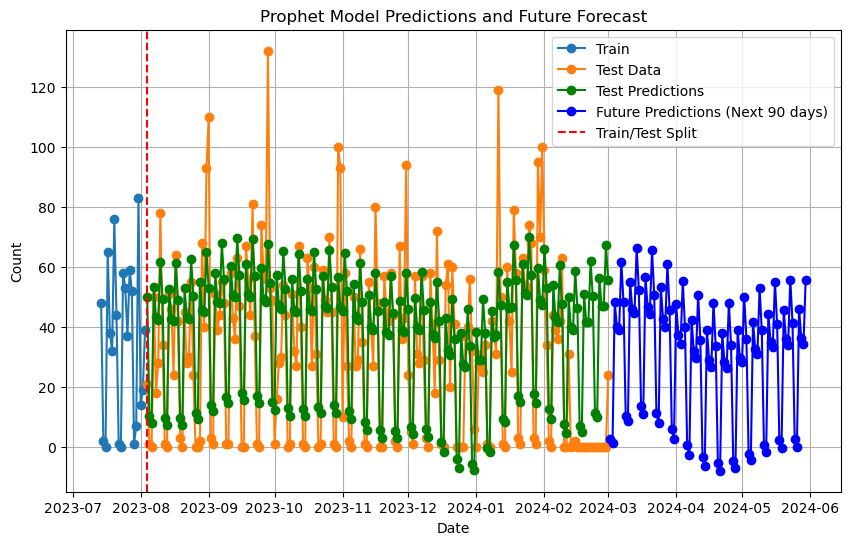

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure the index is a datetime type and prepare data for Prophet
data = sales_data.INVOICEDAT.value_counts().reset_index().sort_values(by='INVOICEDAT').reset_index(drop=True)
data = data.set_index('INVOICEDAT')
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# Prophet requires columns named 'ds' (datetime) and 'y' (target variable)
data_prophet = data.reset_index().rename(columns={'INVOICEDAT': 'ds', 'count': 'y'})

# Handle missing values
data_prophet['y'] = data_prophet['y'].fillna(0)  # Or use forward fill, interpolation, etc.

# Split the data into training and test sets (for evaluation purposes)
train_size = int(len(data_prophet) * 0.8)
train_data, test_data = data_prophet[:train_size], data_prophet[train_size:]

# Initialize and fit the Prophet model on the training data
model = Prophet()
model.fit(train_data)

# Make predictions on the test set
future = model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = model.predict(future)

# Get the predicted values for the test set
predictions = forecast[['ds', 'yhat']].set_index('ds').loc[test_data['ds']]

# Calculate error metrics for test data predictions
mae = mean_absolute_error(test_data['y'], predictions['yhat'])
mse = mean_squared_error(test_data['y'], predictions['yhat'])
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")

# Train the model again on the entire dataset for future forecasting
model_full = Prophet()
model_full.fit(data_prophet)

# Forecast for the next three months (approx. 90 days)
future_steps = 90
future_dates = model_full.make_future_dataframe(periods=future_steps, freq='D')
future_forecast = model_full.predict(future_dates)

# Get future predictions
future_predictions = future_forecast[['ds', 'yhat']].set_index('ds').iloc[-future_steps:]

# Optional: Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
# Test data plot
plt.plot(train_data['ds'][820:], train_data['y'][820:], label='Train', marker='o')
plt.plot(test_data['ds'], test_data['y'], label='Test Data', marker='o')
# Predictions on test set plot
plt.plot(predictions.index, predictions['yhat'], label='Test Predictions', color='g', marker='o')
# Future forecast plot
plt.plot(future_predictions.index, future_predictions['yhat'], label='Future Predictions (Next 90 days)', color='blue', marker='o')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Prophet Model Predictions and Future Forecast')

# Mark the Train/Test split with a vertical line
plt.axvline(test_data['ds'].iloc[0], color='r', linestyle='--', label='Train/Test Split')

# Legend and grid
plt.legend()
plt.grid()
plt.show()


15:47:56 - cmdstanpy - INFO - Chain [1] start processing
15:47:56 - cmdstanpy - INFO - Chain [1] done processing
15:47:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error (Test): 118.13410832438073
Mean Squared Error (Test): 16944.323100116588


15:47:57 - cmdstanpy - INFO - Chain [1] done processing


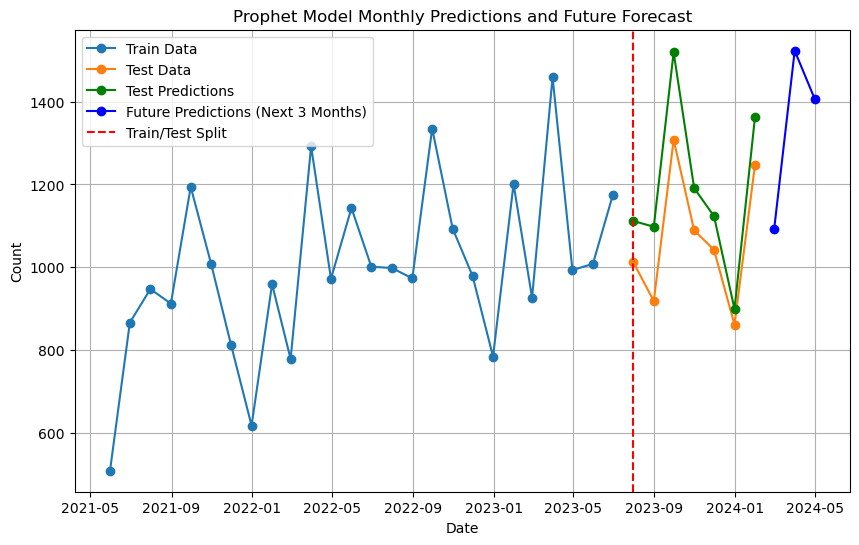

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure the index is a datetime type and prepare data for Prophet
data = sales_data.INVOICEDAT.value_counts().reset_index().sort_values(by='INVOICEDAT').reset_index(drop=True)
data = data.set_index('INVOICEDAT')
data.index = pd.to_datetime(data.index)

# Convert the data to monthly frequency and sum values within each month
data = data.resample('M').sum()

data = data[(data.index > data.index.min()) & (data.index < data.index.max())]
data = data[(data.index < data.index.max())]

# Aggregate the data by month and sum the 'count' column
monthly_data = data

# Reset index and prepare data for Prophet
data_prophet = monthly_data.reset_index().rename(columns={'INVOICEDAT': 'ds', 'count': 'y'})

# Handle missing values (optional)
data_prophet['y'] = data_prophet['y'].fillna(0)

# Split the data into training and test sets (for evaluation purposes)
train_size = int(len(data_prophet) * 0.8)
train_data, test_data = data_prophet[:train_size], data_prophet[train_size:]

# Initialize and fit the Prophet model on the training data
model = Prophet()
model.fit(train_data)

# Make predictions on the test set
future = model.make_future_dataframe(periods=len(test_data), freq='M')  # Monthly frequency
forecast = model.predict(future)

# Get the predicted values for the test set
predictions = forecast[['ds', 'yhat']].set_index('ds').loc[test_data['ds']]

# Calculate error metrics for test data predictions
mae = mean_absolute_error(test_data['y'], predictions['yhat'])
mse = mean_squared_error(test_data['y'], predictions['yhat'])
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")

# Train the model again on the entire dataset for future forecasting
model_full = Prophet()
model_full.fit(data_prophet)

# Forecast for the next 3 months
future_steps = 3
future_dates = model_full.make_future_dataframe(periods=future_steps, freq='M')  # Monthly frequency
future_forecast = model_full.predict(future_dates)

# Get future predictions for the next 3 months
future_predictions = future_forecast[['ds', 'yhat']].set_index('ds').iloc[-future_steps:]

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
# Train data plot (Optional, adjust based on dataset size)
plt.plot(train_data['ds'], train_data['y'], label='Train Data', marker='o')
# Test data plot
plt.plot(test_data['ds'], test_data['y'], label='Test Data', marker='o')
# Predictions on test set plot
plt.plot(predictions.index, predictions['yhat'], label='Test Predictions', color='g', marker='o')
# Future forecast plot
plt.plot(future_predictions.index, future_predictions['yhat'], label='Future Predictions (Next 3 Months)', color='blue', marker='o')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Prophet Model Monthly Predictions and Future Forecast')

# Mark the Train/Test split with a vertical line
plt.axvline(test_data['ds'].iloc[0], color='r', linestyle='--', label='Train/Test Split')

# Legend and grid
plt.legend()
plt.grid()
plt.show()


10:26:09 - cmdstanpy - INFO - Chain [1] start processing
10:26:09 - cmdstanpy - INFO - Chain [1] done processing


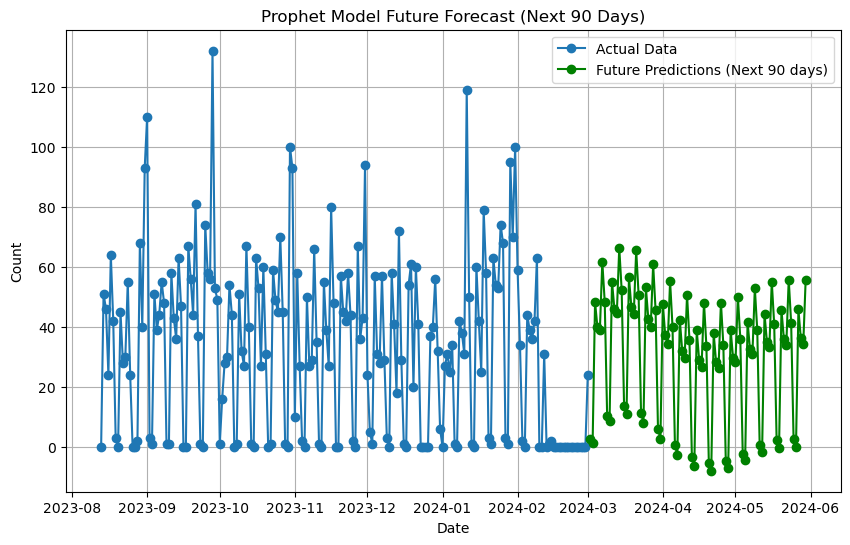

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Ensure the index is a datetime type and prepare data for Prophet
data = sales_data.INVOICEDAT.value_counts().reset_index().sort_values(by='INVOICEDAT').reset_index(drop=True)
data = data.set_index('INVOICEDAT')
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# Prophet requires columns named 'ds' (datetime) and 'y' (target variable)
data_prophet = data.reset_index().rename(columns={'INVOICEDAT': 'ds', 'count': 'y'})

# Handle missing values
data_prophet['y'] = data_prophet['y'].fillna(0)  # Or use forward fill, interpolation, etc.

# Initialize and fit the Prophet model on the entire dataset
model = Prophet()
model.fit(data_prophet)

# Forecast for the next three months (approx. 90 days)
future_steps = 90
future_dates = model.make_future_dataframe(periods=future_steps, freq='D')  # Daily frequency
future_forecast = model.predict(future_dates)

# Get future predictions
future_predictions = future_forecast[['ds', 'yhat']].set_index('ds').iloc[-future_steps:]

# Optional: Plot the future forecast
plt.figure(figsize=(10, 6))
# Plot the actual data
plt.plot(data_prophet['ds'][850:], data_prophet['y'][850:], label='Actual Data', marker='o')
# Plot future forecast
plt.plot(future_predictions.index, future_predictions['yhat'], label='Future Predictions (Next 90 days)', color='g', marker='o')
# Labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Prophet Model Future Forecast (Next 90 Days)')

# Legend and grid
plt.legend()
plt.grid()
plt.show()


15:36:32 - cmdstanpy - INFO - Chain [1] start processing
15:36:32 - cmdstanpy - INFO - Chain [1] done processing


                   yhat
ds                     
2024-02-29  1092.754449
2024-03-31  1523.078907
2024-04-30  1407.517451


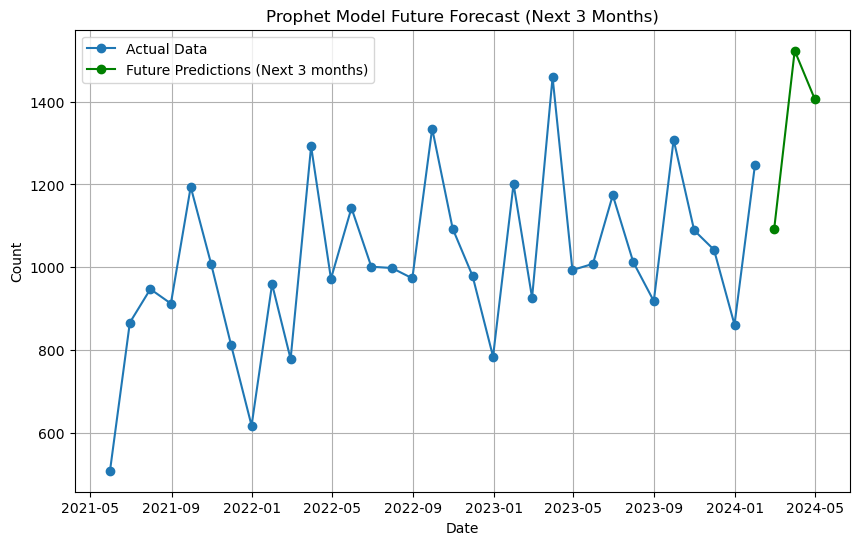

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Ensure the index is a datetime type and prepare data for Prophet
data = sales_data.INVOICEDAT.value_counts().reset_index().sort_values(by='INVOICEDAT').reset_index(drop=True)
data = data.set_index('INVOICEDAT')
data.index = pd.to_datetime(data.index)

# Convert the data to monthly frequency and sum values within each month
data = data.resample('M').sum()

data = data[(data.index > data.index.min()) & (data.index < data.index.max())]
data = data[(data.index < data.index.max())]

# Prophet requires columns named 'ds' (datetime) and 'y' (target variable)
data_prophet = data.reset_index().rename(columns={'INVOICEDAT': 'ds', 'count': 'y'})

# Handle missing values
data_prophet['y'] = data_prophet['y'].fillna(0)  # Or use forward fill, interpolation, etc.

# Initialize and fit the Prophet model on the entire dataset
model = Prophet()
model.fit(data_prophet)

# Forecast for the next three months (monthly frequency)
future_steps = 3
future_dates = model.make_future_dataframe(periods=future_steps, freq='M')  # Monthly frequency
future_forecast = model.predict(future_dates)

# Get future predictions
future_predictions = future_forecast[['ds', 'yhat']].set_index('ds').iloc[-future_steps:]
print(future_predictions)

# Optional: Plot the future forecast
plt.figure(figsize=(10, 6))
# Plot the actual data
plt.plot(data_prophet['ds'], data_prophet['y'], label='Actual Data', marker='o')
# Plot future forecast
plt.plot(future_predictions.index, future_predictions['yhat'], label='Future Predictions (Next 3 months)', color='g', marker='o')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Prophet Model Future Forecast (Next 3 Months)')

# Legend and grid
plt.legend()
plt.grid()
plt.show()


In [4]:
data

NameError: name 'data' is not defined